In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use('/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/modulo')

In [149]:

# Define the neural network for f_theta(x)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.Gelu = nn.GELU()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.Gelu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the wavefunction psi(x) = x(x - L)f_theta(x)
def wavefunction(x, L, f_theta):
    return x * (x - L) * f_theta(x)
    
def wavefunction_n(x, L, f_theta):
    psi=wavefunction(x, L, f_theta)
    norm = torch.sqrt(torch.trapz(psi**2,x,dim=0))
    return psi/norm

# Define the physics loss
def physics_loss(x, L, f_theta, hbar, m, E):
    x.requires_grad_(True)
    psi = wavefunction_n(x, L, f_theta)
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    residual = (-hbar**2 / (2 * m)) * d2psi_dx2 - E * psi
    return torch.mean(residual**2)

# Training loop
def train_pinn(L, hbar, m, E, num_epochs=1300, lr=0.01):
    f_theta = NeuralNetwork()
    optimizer = optim.Adam(f_theta.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x = torch.linspace(0, L, 100).unsqueeze(1)  # Collocation points
        loss = physics_loss(x, L, f_theta, hbar, m, E)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return f_theta

# Parameter

In [2]:
# Define the neural network for f_theta(x)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        #self.fc2 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)
        self.Gelu = nn.GELU()
    def forward(self, x):
        x = self.Gelu(self.fc1(x))
        #x = torch.tanh(self.fc2(x))
        x = self.fc2(x)
        return x

# Define the wavefunction psi(x) = x(x - L)f_theta(x)
def wavefunction(x, L, f_theta):
    return x * (x - L) * f_theta(x)
    
def wavefunction_n(x, L, f_theta):
    psi=wavefunction(x, L, f_theta)
    norm = torch.sqrt(torch.trapz(psi**2,x,dim=0))
    return psi/norm
    
# Define the normalization loss
def normalization_loss(x, const, f_theta):
    psi = wavefunction(x, const, f_theta)
    integral = torch.trapz(psi**2, x, dim=0)  # Numerical integration
    return integral,(integral - 1.0)**2
    
# Define the physics loss
def physics_loss_PIB(x, L, f_theta, hbar, m, E):
    x.requires_grad_(True)
    psi = wavefunction(x, L, f_theta)
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    residual = (-hbar**2 / (2 * m)) * d2psi_dx2 - E * psi
    return torch.mean(residual**2)

# Training loop
def train_pinn_PIB(L, hbar, m, E, num_epochs=5000, lr=0.01,ONB=[]):
    f_theta = NeuralNetwork()
    optimizer = optim.Adam(f_theta.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x = torch.linspace(0, L, 100).unsqueeze(1)  # Collocation points
        loss_pde = physics_loss_PIB(x, L, f_theta, hbar, m, E)
        norm, loss_norm = normalization_loss(x, L, f_theta)
        loss_orth=0
        for (i,f) in enumerate(ONB):
            psi = wavefunction(x, L, f_theta)
            psi_i = wavefunction(x, L, f)
            loss_orth += torch.trapz((psi*psi_i),x,dim=0)**2
            
        loss=loss_pde/norm + loss_orth + loss_norm
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return f_theta

In [3]:
import numpy as np
#x = np.linspace(0,L)

def normal_NN_PIB(func,L):
    x = torch.linspace(0, L, 100).unsqueeze(1)
    psi = wavefunction(x, L, func)
    y = psi/torch.sqrt(torch.trapz(psi**2,x,dim=0))
    yn = y.detach().numpy()
    xn = np.linspace(0, L, 100)
    yn= np.reshape(yn,len(yn))
    return xn, yn
    
def psi_n(x,n):
    return (2/L)**0.5*np.sin(n*np.pi*x/L)

def energy_PIB(f_theta,L,x):
    x.requires_grad_(True)
    psi = wavefunction(x, L, f_theta)
    norm = torch.trapz(psi**2, x, dim=0)
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    E = torch.trapz((-hbar**2 / (2 * m)) * d2psi_dx2*psi,x,dim=0)/norm
    return E.item()

Epoch 0, Loss: 0.35960766673088074
Epoch 500, Loss: 0.0017702656332403421
Epoch 1000, Loss: 0.0001492961891926825
Epoch 1500, Loss: 5.6384025810984895e-05
Epoch 2000, Loss: 5.1072762289550155e-05
Epoch 2500, Loss: 4.622786582331173e-05
Epoch 3000, Loss: 4.0423241443932056e-05
Epoch 3500, Loss: 3.353481224621646e-05
Epoch 4000, Loss: 2.5612394892959855e-05
Epoch 4500, Loss: 1.7161555661004968e-05
For n=1, E=0.5000028610229492, anal = 0.5
Epoch 0, Loss: 5.473592758178711
Epoch 500, Loss: 0.0017592823132872581
Epoch 1000, Loss: 0.0002132105582859367
Epoch 1500, Loss: 6.402282451745123e-05
Epoch 2000, Loss: 1.4547504179063253e-05
Epoch 2500, Loss: 3.779545750148827e-06
Epoch 3000, Loss: 2.438582214381313e-06
Epoch 3500, Loss: 1.071209590008948e-05
Epoch 4000, Loss: 1.0489759915799368e-05
Epoch 4500, Loss: 4.061756499140756e-06
For n=2, E=2.0000011920928955, anal = 2.0
Epoch 0, Loss: 4.989986419677734
Epoch 500, Loss: 0.0595894530415535
Epoch 1000, Loss: 0.011201782152056694
Epoch 1500, Los

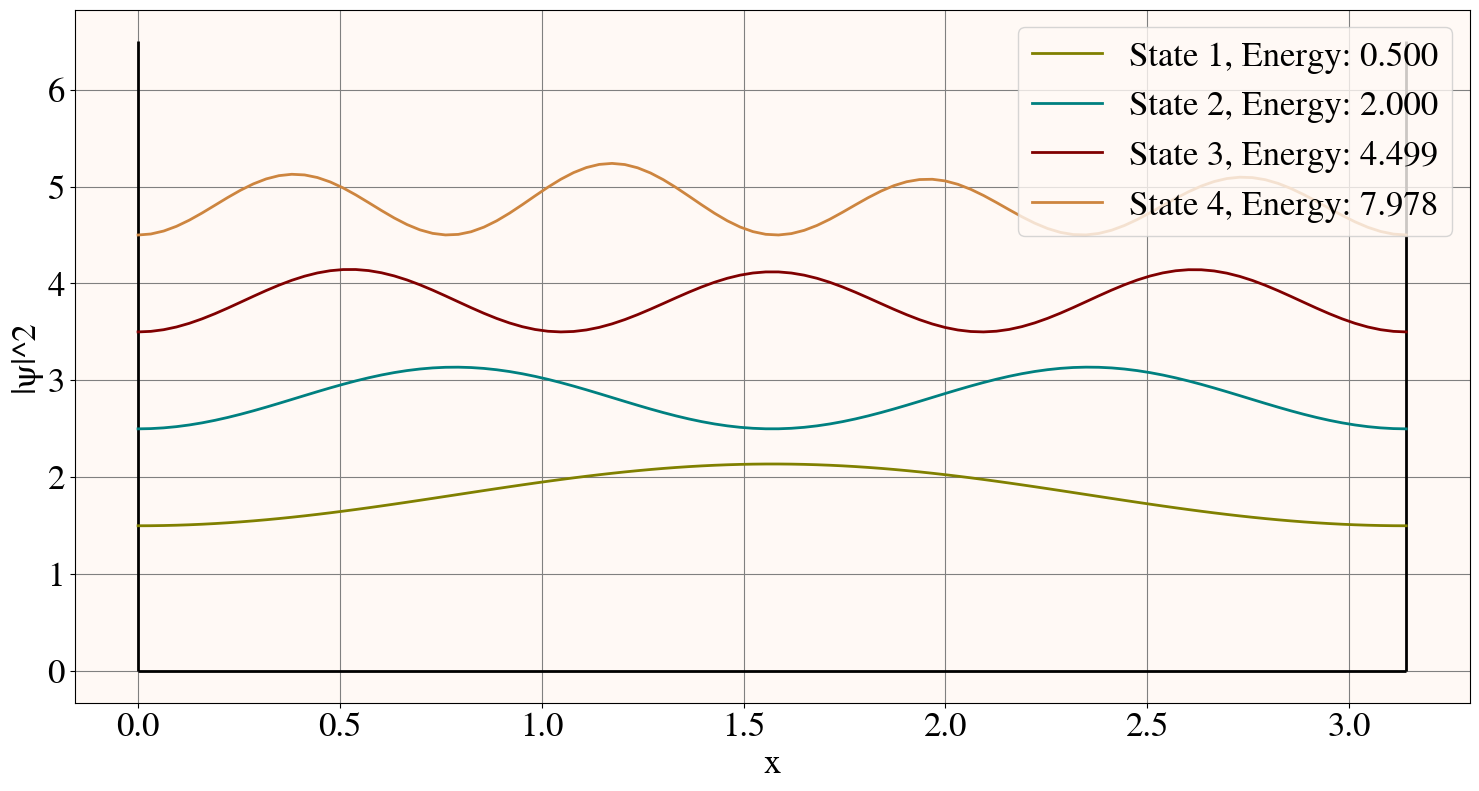

In [7]:
L=np.pi
N=1000
max_n=5
hbar = 1.0  # Reduced Planck constant
m = 1.0  # Mass of the particle
x=torch.linspace(0, L, N).unsqueeze(1)
plt.hlines(0,0,L,color="k")
plt.vlines(0,0,max_n+1.5,color="k")
plt.vlines(L,0,max_n+1.5,color="k")
# Train the PINN
ONB = []
for n in range(1,max_n):
    E = n**2*np.pi**2/(2*L**2)
    f_theta = train_pinn_PIB(L, 1, 1, E, ONB=ONB)
    ONB.append(f_theta)
    x=torch.linspace(0, L, 1000).unsqueeze(1)
    En = energy_PIB(f_theta,L,x)
    print(f"For n={n}, E={En}, anal = {E}")
    x,y=normal_NN_PIB(f_theta,L)
    plt.plot(x,y**2+n+0.5,label=f"State {n}, Energy: {En:.3f}")

plt.xlabel("x")
plt.legend(loc="upper right")
plt.ylabel("|ψ|^2")
plt.show()

In [8]:
def wavefunction(x, const, f_theta):
    return f_theta(x)

# Define the physics loss
def physics_loss_QHO(x, alpha, f_theta, hbar, m, omega, E):
    x.requires_grad_(True)
    psi = wavefunction(x, alpha, f_theta)
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    residual = (-hbar**2 / (2 * m)) * d2psi_dx2 + (0.5 * m * omega**2 * x**2) * psi - E * psi
    return torch.mean(residual**2)

# Training loop
def train_pinn_QHO(alpha, hbar, m, omega, E, num_epochs=10000, lr=0.001,ONB=[]):
    f_theta = NeuralNetwork()
    optimizer = optim.Adam(f_theta.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x = torch.linspace(-3, 3, 200).unsqueeze(1)  # Collocation points in [-5, 5]
        x.requires_grad_(True)

        # Compute losses
        phys_loss = physics_loss_QHO(x, alpha, f_theta, hbar, m, omega, E)
        norm,norm_loss = normalization_loss(x, alpha, f_theta)
        loss_orth=0
        for (i,f) in enumerate(ONB):
            psi = wavefunction(x, alpha, f_theta)
            alphai=0.5/(1+i)
            psi_i = wavefunction(x, alphai, f)
            loss_orth += torch.trapz((psi*psi_i),x,dim=0)**2
        
        total_loss = phys_loss*100/norm**2 + norm_loss + loss_orth*100 # Combine losses

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item()}, Norm: {norm.item()},ONB: {loss_orth}")

    return f_theta

In [9]:
def normal_NN_QHO(func,L,N):
    x = torch.linspace(-L, L, N).unsqueeze(1)
    psi = wavefunction(x, L, func)
    y = psi/torch.sqrt(torch.trapz(psi**2,x,dim=0))
    yn = y.detach().numpy()
    xn = np.linspace(-L, L, N)
    yn= np.reshape(yn,len(yn))
    return xn, yn
    
def psi_n(x,L,n):
    return (2/L)**0.5*np.sin(n*np.pi*x/L)

In [10]:
def energy_QHO(f_theta,alpha,x):
    x.requires_grad_(True)
    psi = wavefunction(x, alpha, f_theta)
    norm = torch.trapz(psi**2, x, dim=0)
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0]
    E = torch.trapz((-hbar**2 / (2 * m)) * d2psi_dx2*psi + (0.5 * m * omega**2 * x**2) * psi**2,x,dim=0)/norm
    return E.item()

Epoch 0, Loss: 527.3265380859375, Norm: 0.1581512689590454,ONB: 0
Epoch 500, Loss: 3.1502950191497803, Norm: 1.7687777280807495,ONB: 0
Epoch 1000, Loss: 2.3780057430267334, Norm: 1.6617838144302368,ONB: 0
Epoch 1500, Loss: 1.4366453886032104, Norm: 1.4146991968154907,ONB: 0
Epoch 2000, Loss: 0.39010995626449585, Norm: 1.013620376586914,ONB: 0
Epoch 2500, Loss: 0.04253725707530975, Norm: 0.8856685757637024,ONB: 0
Epoch 3000, Loss: 0.010462980717420578, Norm: 0.9573909044265747,ONB: 0
Epoch 3500, Loss: 0.00326145370490849, Norm: 0.9855020642280579,ONB: 0
Epoch 4000, Loss: 0.0010815723799169064, Norm: 0.9944498538970947,ONB: 0
Epoch 4500, Loss: 0.00040674046613276005, Norm: 0.9977439641952515,ONB: 0
Epoch 5000, Loss: 0.0001878378534456715, Norm: 0.9991515278816223,ONB: 0
Epoch 5500, Loss: 0.000101695884950459, Norm: 0.9997080564498901,ONB: 0
Epoch 6000, Loss: 6.412065704353154e-05, Norm: 0.9999188780784607,ONB: 0
Epoch 6500, Loss: 4.531455851974897e-05, Norm: 0.9999959468841553,ONB: 0
Epo

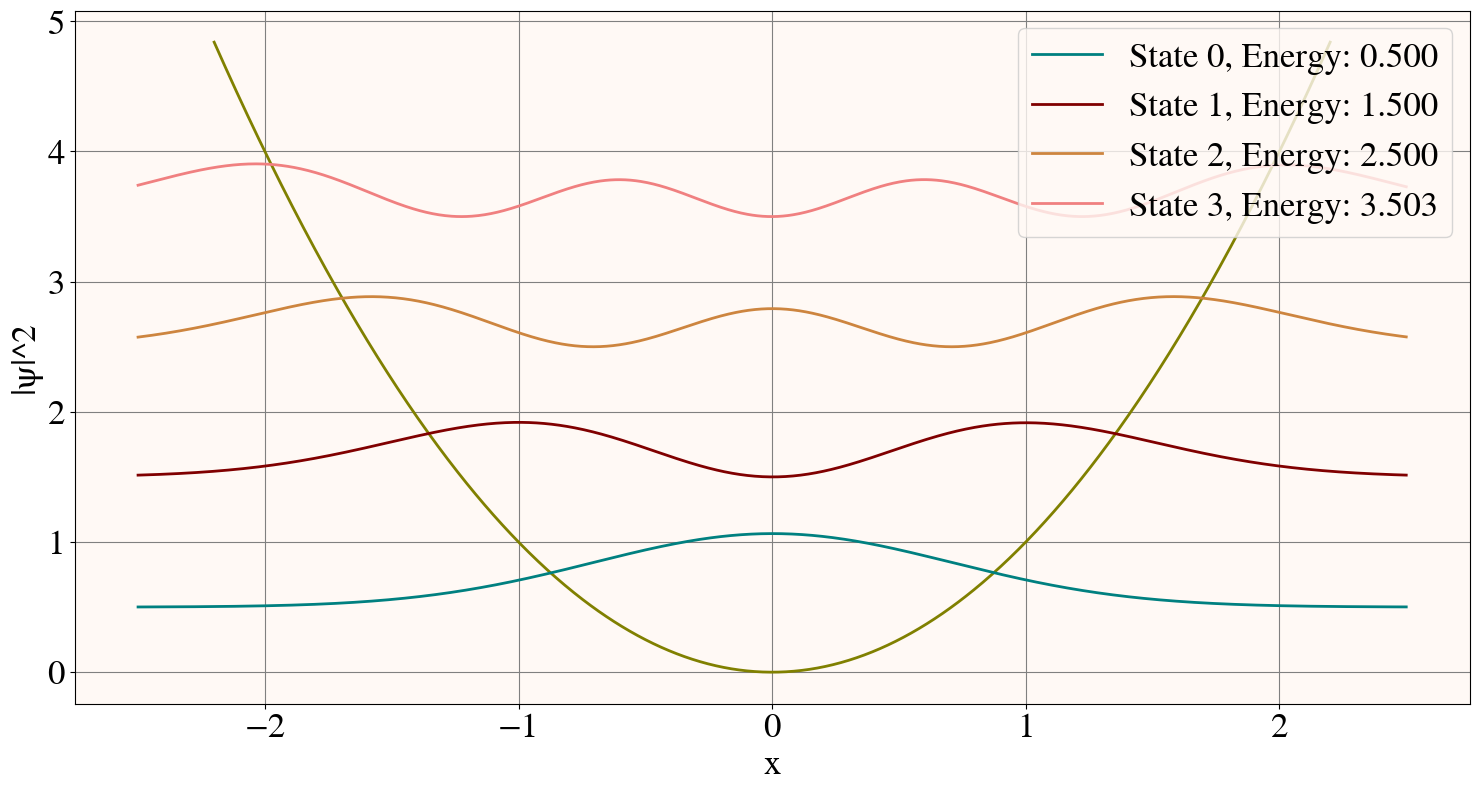

In [11]:
L=2.5
N=1000
omega = 1.0  # Angular frequency
x_plot=torch.linspace(-2.2, 2.2, N).unsqueeze(1)
plt.plot(x_plot,x_plot**2)
# Train the PINN
ONB = []
for n in range(0,4):
    E = n+0.5
    alpha=0.5/(n+1)
    f_theta = train_pinn_QHO(alpha, hbar, m, omega, E,ONB=ONB)
    ONB.append(f_theta)
    x=torch.linspace(-L, L, 1000).unsqueeze(1)
    En = energy_QHO(f_theta,alpha,x)
    print(f"For n={n}, E={En}")
    x,y=normal_NN_QHO(f_theta,L,N)
    plt.plot(x,y**2+n+0.5,label=f"State {n}, Energy: {En:.3f}")

plt.xlabel("x")
plt.legend(loc="upper right")
plt.ylabel("|ψ|^2")
plt.show()